<a href="https://colab.research.google.com/github/jacksonliang35/Polish-POS-Tagging/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This script predicts the POS tag (and ctag) of a word using the last few characters (by a window) of its orth form (i.e., original word) and its lemma.

Note on ctag: In addition to the POS tags, ctag contains additional information, e.g., singularity, gender, person... For a list of ctags and POS tags, please see: http://nkjp.pl/poliqarp/help/ense2.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/UIUC/pos_tagging/Code

/content/drive/MyDrive/UIUC/pos_tagging/Code


In [ ]:
## Imports
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

Following is a function used to parse xml into list of list.

In [ ]:
def read_data(path):
    ## Parse xml file
    tree = ET.parse(path)
    root = tree.getroot()
    ## Construct list of list
    data = []
    label = []
    lexicon = []
    for chunk in root:
        cur_data = []
        cur_label = []
        cur_lex = []
        for tok in chunk:
            if tok.tag != 'ns':
                cur_data.append(tok.find('orth').text.lower())
                cur_lex.append(tok.find('lex').find('base').text.lower())
                # cur_label.append(tok.find('lex').find('ctag').text.split(":")[0])
                cur_label.append(tok.find('lex').find('ctag').text)
        data.append(cur_data)
        label.append(cur_label)
        lexicon.append(cur_lex)
    return data,label,lexicon

Following is a function that converts list of list into pandas dataframe.

In [ ]:
def lol2df(data, label, lexicon, char_len=3):
    assert(len(data)==len(label))
    # Prepare list of list
    data2df = []
    for l in range(len(data)):
        for t in range(len(data[l])):
            temp = [data[l][t]]
            temp.append(len(data[l][t]))
            for c in range(1,char_len+1):
                try:
                    temp.append(data[l][t][-c])
                except IndexError:
                    temp.append('_')
            temp.append(lexicon[l][t])
            # Finally, append the ctag class
            temp.append(label[l][t])
            data2df.append(temp)
    # Convert to df
    cname = ['word', 'length'] + ['c[-'+str(i)+']' for i in range(1,char_len+1)] + ['lex'] + ['class']
    return pd.DataFrame(data2df, columns=cname)

Reading files...

In [ ]:
# Input and combine data (will use 5-fold CV)
trdata, trlabel, trlex = read_data('../Data/train.xml')
valdata, vallabel, vallex = read_data('../Data/validate.xml')

In [ ]:
C = 3
# Will use 5-fold CV
data = pd.concat([lol2df(trdata, trlabel, trlex, char_len=C), lol2df(valdata, vallabel, vallex, char_len=C)], ignore_index=True)
data.head(n=10)

,word,length,c[-1],c[-2],c[-3],lex,class
0,zabiję,6,ę,j,i,zabić,fin:sg:pri:perf
1,cię,3,ę,i,c,ty,ppron12:sg:acc:m1:sec:nakc
2,",",1,",",_,_,",",interp
3,jeśli,5,i,l,ś,jeśli,comp
4,umrzesz,7,z,s,e,umrzeć,fin:sg:sec:perf
5,!,1,!,_,_,!,interp
6,"""",1,"""",_,_,"""",interp
7,cieszy,6,y,z,s,cieszyć,fin:sg:ter:imperf
8,fakt,4,t,k,a,fakt,subst:sg:nom:m3
9,",",1,",",_,_,",",interp


The features selected are: **Word form, Word length, Word lemma, and last few characters**. The last of these is chosen because the suffix information is potentially helpful for POS classification.

In [ ]:
tedata, telabel, telex = read_data('../Data/test.xml')
tdata = lol2df(tedata, telabel, telex, char_len=C)

Pre-processing labels...

In [ ]:
label_enc = LabelEncoder().fit(pd.concat([data['class'], tdata['class']]))
y = label_enc.transform(data['class'])
X = data.drop(columns=['class'])
y_test = label_enc.transform(tdata['class'])
X_te = tdata.drop(columns=['class'])

Following is a wrapper to analyze classifiers with 5-fold CV.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
def trainPrep(X_tr, X_te, y_tr):
    # Encode Features
    ## Append fake data
    y_fake = np.unique(y_tr)
    X_fake = []
    for f in X_tr.iloc[0,:]:
        if isinstance(f,np.int64):
            X_fake.append(0)
        else:
            X_fake.append('<UNK>')
    X_fake = pd.DataFrame([X_fake]*len(y_fake), columns=X_tr.columns)
    X_train_all = pd.concat([X_tr,X_fake], ignore_index=True)
    y_train = np.append(y_tr, y_fake)
    
    ## Pre-process features (also replacing unseen test instances)
    pd.options.mode.chained_assignment = None     # suppress warnings
    X_train = []
    X_test = []
    
    ## Randomly cover up some instances to make predictions more robust
    ## Lexicon
    if 'lex' in X_train_all:
        lex_enc = LabelEncoder().fit(X_train_all['lex'])
        X_te.loc[~X_te['lex'].isin(lex_enc.classes_),'lex'] = '<UNK>'
        X_train.append(lex_enc.transform(X_train_all['lex']).reshape(-1,1))
        X_test.append(lex_enc.transform(X_te['lex']).reshape(-1,1))
    ## Word
    if 'word' in X_train_all:
        word_enc = LabelEncoder().fit(X_train_all['word'])
        X_te.loc[~X_te['word'].isin(word_enc.classes_),'word'] = '<UNK>'
        X_train.append(word_enc.transform(X_train_all['word']).reshape(-1,1))
        X_test.append(word_enc.transform(X_te['word']).reshape(-1,1))
    ## Length
    if 'length' in X_train_all:
        X_train.append(X_train_all['length'].values.reshape(-1,1))
        X_test.append(X_te['length'].values.reshape(-1,1))
    ## Last char's
    char_idx = X_train_all.columns.str.startswith('c[')
    X_train_all_char = X_train_all.loc[:,char_idx]
    char_enc = LabelEncoder().fit(X_train_all_char.values.flatten())
    X_te_char = X_te.loc[:,char_idx].values.flatten()
    X_te_char[~np.isin(X_te_char,char_enc.classes_)] = '<UNK>'
    X_train.append(char_enc.transform(X_train_all_char.values.flatten()).reshape(-1,sum(char_idx)))
    X_test.append(char_enc.transform(X_te_char).reshape(-1,sum(char_idx)))
    
    # Stacking
    X_train = np.hstack(X_train)
    X_test = np.hstack(X_test)

    # Scaling
    ss = MinMaxScaler().fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    
    return X_train, y_train, X_test

In [ ]:
def testClassifierCV(clf, X, y, cv=5):
    # Use 5-fold CV
    kf = KFold(n_splits=cv)
    train_score, val_score = list(), list()
    f1, prec, rec = list(), list(), list()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train, X_test = trainPrep(X_train, X_test, y_train)
        ## Fit classifiers
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        ## Calculate metrics
        train_score.append(clf.score(X_train, y_train))
        val_score.append(clf.score(X_test, y_test))
        f1.append(f1_score(y_test, y_pred, average="micro"))
        prec.append(precision_score(y_test, y_pred, average="micro"))
        rec.append(recall_score(y_test, y_pred, average="micro"))
    print("Average training score:", np.mean(train_score))
    print("Average validation score:", np.mean(val_score))
    return np.mean(f1), np.mean(prec), np.mean(rec)

First, check the performance of POS tag prediction. It is pretty good!

In [ ]:
label_enc_pos = LabelEncoder().fit(data['class'].str.split(":").apply(lambda x: x[0]))
y = label_enc_pos.transform(data['class'].str.split(":").apply(lambda x: x[0]))
# No new POS tags in testset, so the following line works
y_test = label_enc_pos.transform(tdata['class'].str.split(":").apply(lambda x: x[0]))

names = ["Gaussian Naive Bayes", "Decision Tree"]
classifiers = [GaussianNB(), 
               DecisionTreeClassifier()]
for name, clf in zip(names, classifiers):
    print("Current classifier:", name)
    X_train, y_train, X_test = trainPrep(X, X_te, y)
    ## Fit classifiers
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ## Calculate metrics
    p = precision_score(y_test, y_pred, average="micro")
    r = recall_score(y_test, y_pred, average="micro")
    f = f1_score(y_test, y_pred, average="micro")
    print("Test precision:", p)
    print("Test recall:", r)
    print("Test f1 score:", f)
    print("")

Current classifier: Gaussian Naive Bayes
Test precision: 0.5195440342838794
Test recall: 0.5195440342838794
Test f1 score: 0.5195440342838794

Current classifier: Decision Tree
Test precision: 0.9554037865408603
Test recall: 0.9554037865408603
Test f1 score: 0.9554037865408603



Next, focus on predicting the full ctag. Below, 5-fold CV followed by testing.

In [ ]:
y = label_enc.transform(data['class'])
y_test = label_enc.transform(tdata['class'])

names = ["Gaussian Naive Bayes", "Decision Tree"]
classifiers = [GaussianNB(), 
               DecisionTreeClassifier()]
for name, clf in zip(names, classifiers):
    print("Current classifier:", name)
    f,p,r = testClassifierCV(clf, X, y)
    print("Average precision:", p)
    print("Average recall:", r)
    print("Average f1 score:", f)
    print("")

Current classifier: Gaussian Naive Bayes
Average training score: 0.3561873370984643
Average validation score: 0.3549845774213448
Average precision: 0.3549845774213448
Average recall: 0.3549845774213448
Average f1 score: 0.3549845774213448

Current classifier: Decision Tree
Average training score: 0.8628425803603056
Average validation score: 0.790991157721571
Average precision: 0.790991157721571
Average recall: 0.790991157721571
Average f1 score: 0.790991157721571



In [ ]:
clf = xgb.XGBClassifier(method='gpu_hist',objective='multi:softmax')
X_train, y_train, X_test = trainPrep(X, X_te, y)
X_train_xgb = xgb.DMatrix(X_train, y_train)
X_test_xgb = xgb.DMatrix(X_test)

In [ ]:
print("Current classifier:", "XGBoost Classifier")
## Fit classifiers
param = {'max_depth':2, 'eta':0.5, 'objective':'multi:softmax', 'method':'gpu_hist', 'num_class':len(label_enc.classes_)}
clf_xgb = xgb.train(param, X_train_xgb)
# Too slow...

Current classifier: XGBoost Classifier


In [ ]:
clf = DecisionTreeClassifier()
print("Current classifier:", "Decision Tree")
X_train, y_train, X_test = trainPrep(X, X_te, y)
## Fit classifiers
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
## Calculate metrics
p = precision_score(y_test, y_pred, average="micro")
r = recall_score(y_test, y_pred, average="micro")
f = f1_score(y_test, y_pred, average="micro")
print("Test precision:", p)
print("Test recall:", r)
print("Test f1 score:", f)
print("")

Current classifier: Decision Tree
Test precision: 0.7959022366032283
Test recall: 0.7959022366032283
Test f1 score: 0.7959022366032282



Testset analysis below...

In [ ]:
feature_importance = pd.DataFrame({'Feature Names': ['Lexicon', 'Word', 'Word Length', 'Last char', 'Second last char', 'Third last char'],
                                  'Feature Importance': clf.feature_importances_})
feature_importance

,Feature Names,Feature Importance
0,Lexicon,0.365297
1,Word,0.158863
2,Word Length,0.095181
3,Last char,0.159044
4,Second last char,0.116622
5,Third last char,0.104992


Confusion Matrix...

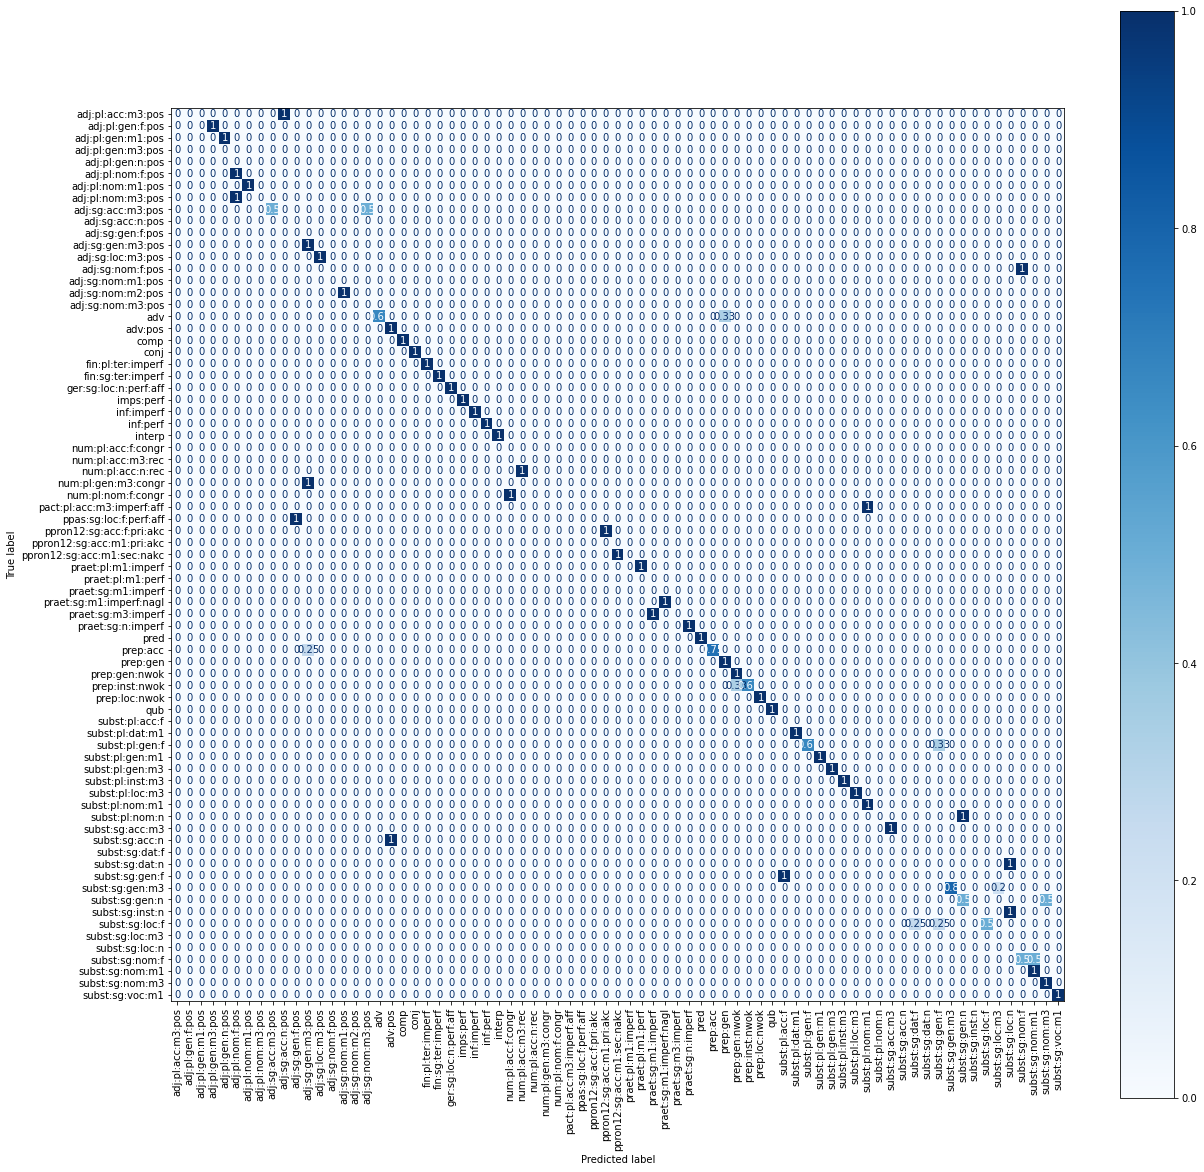

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
# Sample a few points for display
rand_ind = np.random.choice(len(y_test), size=len(y_test)//2000, replace=False)
fig, ax = plt.subplots(figsize=(20, 20))
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay.from_estimator(clf,
                                             X_test[rand_ind],
                                             y_test[rand_ind],
                                             display_labels=label_enc.classes_[np.unique(np.append(y_test[rand_ind],clf.predict(X_test[rand_ind])))],
                                             xticks_rotation='vertical',
                                             cmap=plt.cm.Blues,
                                             normalize='true',
                                             ax=ax
                                             )
plt.show()

Following is for individual feature analysis. For each column *c*, we train a classifier without *c* and examine the difference in performance. This serves as the importance score for column *c*.

In [ ]:
for feat in X:
    print("Deleted feature:", feat)
    Xtemp, ytemp, Xte_temp = trainPrep(X.drop(columns=feat), X_te.drop(columns=feat), y)
    clf.fit(Xtemp, ytemp)
    ypred_temp = clf.predict(Xte_temp)
    print("Precision score:", precision_score(y_test, ypred_temp, average="micro"))
    print("Recall score:", recall_score(y_test, ypred_temp, average="micro"))
    print("F1 score:", f1_score(y_test, ypred_temp, average="micro"))
    print("----------------------------")
    print("")

Deleted feature: word
Precision score: 0.8000765706240506
Recall score: 0.8000765706240506
F1 score: 0.8000765706240506
----------------------------

Deleted feature: length
Precision score: 0.7944325746254832
Recall score: 0.7944325746254832
F1 score: 0.7944325746254832
----------------------------

Deleted feature: c[-1]
Precision score: 0.7864832265049627
Recall score: 0.7864832265049627
F1 score: 0.7864832265049627
----------------------------

Deleted feature: c[-2]
Precision score: 0.7904311420138074
Recall score: 0.7904311420138074
F1 score: 0.7904311420138074
----------------------------

Deleted feature: c[-3]
Precision score: 0.7913903331645487
Recall score: 0.7913903331645487
F1 score: 0.7913903331645488
----------------------------

Deleted feature: lex
Precision score: 0.7884633593097117
Recall score: 0.7884633593097117
F1 score: 0.7884633593097117
----------------------------

